# Trading Simulator with Reinforcement Learning

# Clones, Installs, Imports

## Installs

We need to update the pandas_datareader module to version 0.10.0.

In [1]:
!pip install --upgrade pandas_datareader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 7.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


## Import Librarires



In [2]:
import pandas_datareader as pdr
import datetime 
from scipy import stats
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import count
from torch.distributions import Categorical

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({"axes.grid" : True})
plt.rcParams["figure.figsize"] = (18, 10)


# Load Price Data

The asset you want is in the string `ticker`.  The price data for this asset between `tstart` and `tstop` are loaded into a dataframe.

The date you need for the simulator is `df_price` which has a column for each asset price. 

In [3]:
def create_df_price(tickers:List[str], tstart:str, tstop:str):
  X = []
  for ticker in tickers:
    #ticker = "ETH-USD"

    df = pdr.get_data_yahoo(ticker, start=pd.Timestamp(tstart), 
                              end=pd.Timestamp(tstop))
    df.reset_index(inplace = True)
    df['returns'] = df.Close.pct_change()
    df['ticker'] = ticker
    X.append(df)
  df = pd.concat(X)
  df.reset_index(inplace = True)

  #We need this for trading simulator.  Easier form to work with
  df_price = pd.DataFrame()
  df_price['Date'] = df[df.ticker==tickers[0]]['Date'].values
  for ticker in tickers:
    df_price[f'{ticker}'] = df[df.ticker==ticker]['Close'].values

  print(f"Data has {len(df_price)} steps points per episode")
  return df_price



In [4]:
TICKERS = ['ETH-USD']
tstart = "2022-01-21"
tstop = "2022-11-21"
df_price = create_df_price(TICKERS, tstart, tstop)

Data has 306 steps points per episode


# Plot Returns Data

Returns are the daily percent change in price.  This is a more useful signal for trading than the raw price itself.

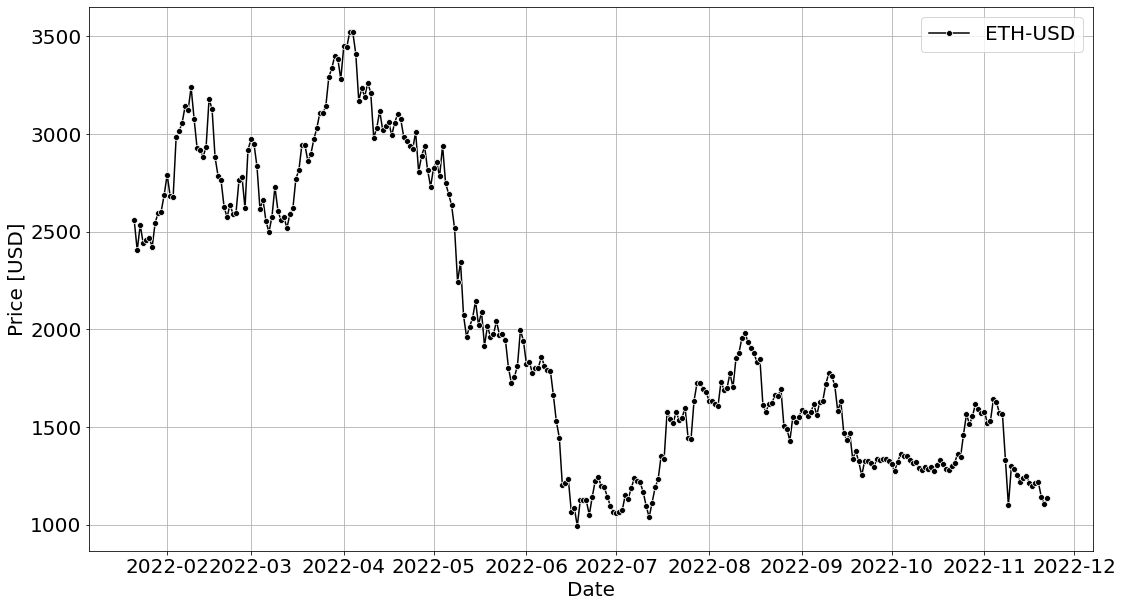

In [5]:
for ticker in TICKERS:
  ax = sns.lineplot(data = df_price, x = 'Date', y = ticker,  
               marker = 'o', label = ticker, color = 'black')
plt.legend()
plt.ylabel("Price [USD]")
plt.show()

# Simulator Environment Class

We need to make the trading simulator act like an OpenAI Gym object to work with our RL code.

The class `TradeSimulator` will simulate a portfolio based on your signals in `df_signals` dataframe and price data for the assets in `df_price`.

We will buy or sell a fixed dollar amount of each asset.    We will close the position in the next period.  Your signals will tell you when to move on an asset.

`TradeSimulator` takes as input:

1) `df_price` = dataframe with price for each asset in each period in each row.

2) `xdaily` = the total buy/sell per period [USD].

3) `initial_cash` = the initial cash in the portfolio [USD].

There is also a function `portfolio_dataframe` used to created a dataframe of the portfolio for plotting.  This function returns as output:

1) `df_portfolio` = dataframe of the value of the portfolio in each period

2) `annual_sharpe` = the annualized sharpe ratio (assuming the periods are 1 day, which I will generalized another day).

In [6]:
class TradeSimulator():
  def __init__(self, df_price, xdaily,initial_cash):
    # Define a 2-D observation space
    self.n_assets = len(df_price.columns) -1
    self.max_steps = len(df_price)-1  #when step == max_steps, done = True, we end one period before so we have next period prices to caluclate reward for step
    self.t = 0  #index in df_price (acts like a time counter)
    self.action_space = [-1,0,1]  #action is an array [0,-1,1,1,0,..] with an element for each asset
    self.price = df_price  #dataframe with prices for each asset
    self.assets = list(df_price.columns[1:])  #ticker for each asset
    self.xdaily = xdaily #daily amount to buy/sell [USD]
    self.initial_cash = initial_cash
    self.value = initial_cash  #inital value of portfolio

  def reset(self):
    # Reset the time step to 0
    self.t = 0
    self.value = self.initial_cash
  
  def step(self, action):
    #action should be an array
    # Flag that marks the termination of an episode
    done = False
    
    # Assert that it is a valid action 
    assert all([a in self.action_space for a in action]), "Invalid action"
    #assert one action for each asset in portfolio
    assert len(action) == self.n_assets  
    #assert the action is an array so we can multiply it and stuff
    assert(type(action)) == np.ndarray

    #calculate value for the trades (this is the reward for the step)
    x0 = self.price.iloc[self.t]
    x1 = self.price.iloc[self.t+1]
    date = x0.values[0]
    price_0 = x0.values[1:]
    price_1 = x1.values[1:]
    price_change = price_1-price_0  #price change over 1 period
    quantity = self.xdaily/price_0/self.n_assets
    #here is where we can throw in a neural network if we are doing RL
    signal = action

    #update portfolio value based on closing positions in next period
    reward =  sum(signal*price_change*quantity) #reward is incremental change in portfolio value [USD]
    self.value += reward  #value is total value of portfolio [USD]
    

    state_index = self.t  #state of the simulator
    value = self.value  #value of portfolio (use this for plotting)
    # If step== max_steps, end the episode.
    # Increase step counter 
    self.t += 1 
    if self.t >= self.max_steps:
        done = True
        #self.reset()

    return state_index, reward, value, done

#this function just creates a dataframe for plotting from the signal and environment (not used in training)
def portfolio_dataframe(env, df_signals):
  env.reset()
  values = []
  for i in range(len(env.price)):
    action = df_signals.iloc[i].values[1:]
    state_index, reward, value, done = env.step(action)
    values.append(value)
    if done: break
  values.append(value)

  df_portfolio = pd.DataFrame()
  df_portfolio['Date']  = env.price['Date']
  df_portfolio['value'] = values
  df_portfolio['returns'] = df_portfolio.value.pct_change()
  mu = df_portfolio.returns.mean()
  vol = df_portfolio.returns.std()
  annual_sharpe = mu/vol*np.sqrt(365)
  return df_portfolio, annual_sharpe 

# Baseline Trading Signals

We will construct a variety of baseline trading signals.  The structure of a signal for testing is as a dataframe `df_signals`.

`df_signals` = dataframe of whether you bought or sold the asset that day.  -1 means sell, 0 means hold, 1 means buy.  You close the position the following day (hopefully for a profit).

`df_signals` columns are `Date`, and the ticker for each asset.  The value for each asset is the signal for that time period.

## Random Signal

`pbuy` = probability of buying an asset
`psell` = probability of selling an asset
`phold` = probability of holding an asset

In [7]:
#Create your signals dataframe, with columns for Date and each asset.  The signal is -1,0,1

#Random signal for testing
pbuy = 0.25
psell = 0.25
phold = 1-pbuy - psell
assert phold>0

df_signals = pd.DataFrame()
df_signals['Date'] = df_price['Date']
for ticker in TICKERS:
  df_signals[ticker] = np.random.choice([-1,0,1], len(df_signals), p=[psell, phold, pbuy])
df_signals_random = df_signals

## Buy Signal

The signal is buy (+1) for each asset, each period

In [8]:
df_signals = pd.DataFrame()
df_signals['Date'] = df_price['Date']
for ticker in TICKERS:
  df_signals[ticker] = 1
df_signals_buy = df_signals

## Sell Signal

The signal is sell (-1) for each asset, each period

In [9]:
df_signals = pd.DataFrame()
df_signals['Date'] = df_price['Date']
for ticker in TICKERS:
  df_signals[ticker] = -1
df_signals_sell = df_signals

# Create Trading Environment for Training

In [11]:
initial_cash = 100  #initial cash you start with [USD]
xdaily = 100  #daily amount to spend/short [USD]
env = TradeSimulator(df_price, xdaily,initial_cash)



# Backtest Baseline Signals

In [12]:
df_portfolio_buy, annual_sharpe_buy = portfolio_dataframe(env, df_signals_buy)
df_portfolio_sell, annual_sharpe_sell = portfolio_dataframe(env, df_signals_sell)
df_portfolio_random, annual_sharpe_random = portfolio_dataframe(env, df_signals_random)


## Plot of Baseline Signal Portfolio Performance

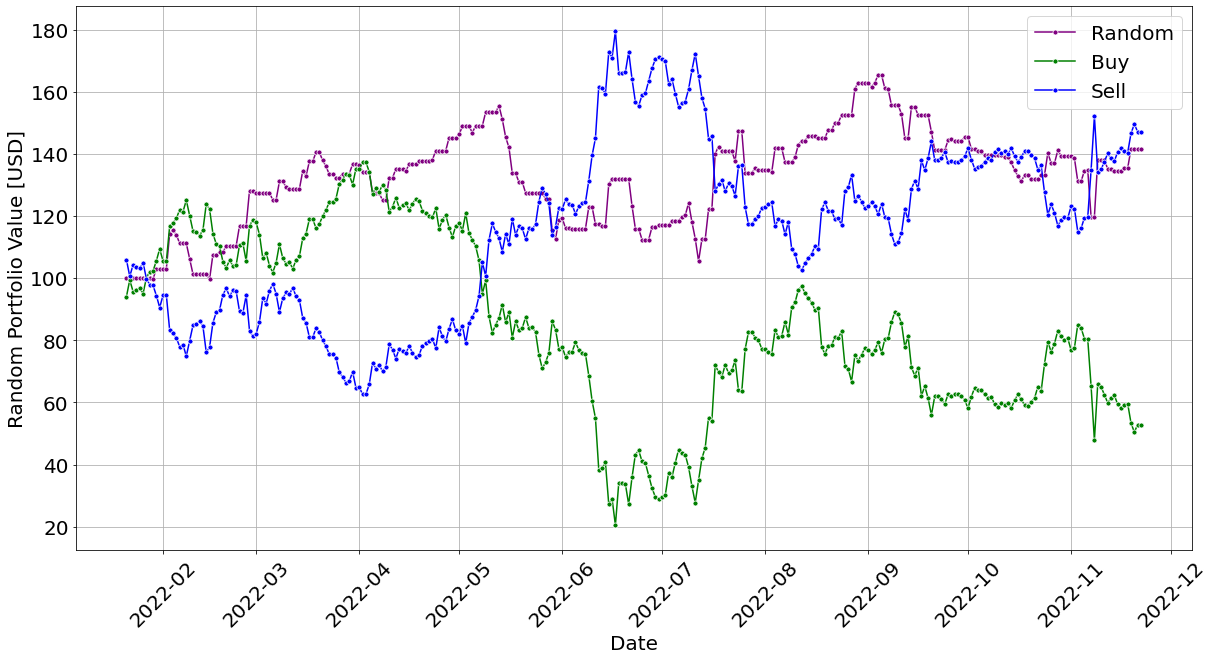

Annualized Sharpe Ratio
Buy: 0.3
Sell: 0.9
Random: 1.0


In [13]:
s=5
plt.figure(figsize=(20,10))
sns.lineplot(data = df_portfolio_random, x = 'Date', y = 'value',marker = 'o', 
             markersize = s, color = 'purple', label = "Random")
sns.lineplot(data = df_portfolio_buy, x = 'Date', y = 'value',marker = 'o', 
             markersize = s, color = 'green', label = "Buy")
sns.lineplot(data = df_portfolio_sell, x = 'Date', y = 'value',marker = 'o', 
             markersize = s, color = 'blue', label = "Sell")
#plt.title(f"Daily Risk = {xdaily} USD, Annual Sharpe Ratio = {annual_sharpe:.1f}")
plt.xticks(rotation = 45)
plt.ylabel("Random Portfolio Value [USD]")
plt.show()
print(f"Annualized Sharpe Ratio")
print(f"Buy: {annual_sharpe_buy:.1f}\nSell: {annual_sharpe_sell:.1f}\nRandom: {annual_sharpe_random:.1f}")

# Neural Network for Trading Agent

In [14]:
class AgentConfig:
    # Learning
    gamma = 0.99
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01
    max_episodes = 100  #maximum training period

    # Memory
    memory_size = 4000  #this should be about 4 x episode length so we get data from 4 episodes per batch


class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3_pi = nn.Linear(64, self.action_size)
        self.fc3_v = nn.Linear(64, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x


# Agent Training Code (Uses PPO)

Use the proximal policy optimization (PPO) algorithm to train the agent.  The step is one trading period.  The reward is the returns for the trades executed that day.  When the episode is done, there is no terminal reward.

The input state is `window` past prices for the `n_assets` assets.  The input dimension to the neural is `window*n_assets`.

## Helper Functions to Format State and Action for Training

In [19]:
#get_state() gets the historic returns of the assets (previous self.window steps) and puts them into a 1-D array
#if we use the prices instead of the returns, we run into training issues (i.e. BTC price is 20K, an DOGE price is 0.06)

def get_state(env,window):
    t = env.t

    assert window>0, "Window is non-positive"
    assets = env.price.columns.values[1:]  #tickers of each assset in portfolio
    if len(assets)==1:  #simpler code for single asset
      asset = assets[0]
      if t>=window:        
        state = env.price.iloc[t - window: t][asset].pct_change().fillna(0).values

      else:
        x = env.price.iloc[0: t][asset].pct_change().fillna(0).values
        x0 = np.repeat(x[0], window-t, axis = 0)
        state = np.concatenate((x0,x))
        assert len(state)==window, f"len(state) = {len(state)}"

    else:  #more than 1 asset
      if t>=window:  #we are deep into the simulator, so we can go back window steps with no problem
        for c,asset in enumerate(assets):
          if c ==0:
            state = env.price.iloc[t - window: t][asset].pct_change().fillna(0).values
          else:      
            x  = env.price.iloc[t - window: t][asset].pct_change().fillna(0).values
            state = np.vstack((state,x))
        state = state.T
      else:  #otherwise we will fill in the previous returns with the initial returns values for window - t steps
        for c,asset in enumerate(assets):
          if c ==0:
            x = env.price.iloc[0: t][asset].pct_change().fillna(0).values
          else:
            xi = env.price.iloc[0: t][asset].pct_change().fillna(0).values
            x = np.vstack((x,xi))
        x = x.T  #x is the returns from 0 to t
        x0 = np.repeat(x[0,:], window-t, axis = 0).reshape(len(assets),window-t,).T  #x0 is the initial returns repeated window - t times
        
        state = np.vstack((x0,x))

      assert state.shape[0] == window  #the height of state should equal window.  This is a 2D array we need to reshape
      state = state.T.reshape((1, state.shape[0]*state.shape[1]))[0]  #reshape state into a 1D array
    return state.astype(float)  #need state to be a float array

#get_action turns the action index (0 to 3^(nassets-1)) into an array of length nassets with -1,0,1 put in.
#this will not scale for more than a few assets, so will have to modify this when we get serious
#example mapping of action_index to action for 3 assets:
#0 = (-1,-1-1), 1 = (-1,-1,0), 2 = (-1,-1,1), ..., 8 = (1,1,1)
def get_action(env,action_index):  
    assert action_index<=3**env.n_assets-1, "Action_index too large"
    if action_index == 0:  #0 = sell everything, or (-1,-1,...,-1)
        return -1*np.ones(env.n_assets)
    else:
        nums = -1*np.ones(env.n_assets)
        n  = action_index
        k = 0
        while n>0:
            n, r = divmod(n, 3)
            nums[k] = r-1
            k+=1
    action = nums[::-1]
    return action

## Agent Class

In [21]:
class Agent(AgentConfig):
    def __init__(self, env, window, winning_score):
        assert window>0, "Window is non-positive"
        self.winning_score = winning_score
        self.env = env
        self.n_assets = env.n_assets
        self.action_size = 3**self.n_assets  #actions are -1 (sell), 0 (hold), and 1 (buy) for each asset
        self.window = window
        self.input_size = self.window*self.n_assets   #input_size is price of each asset for each step in window 
        self.policy_network = MlpPolicy(action_size=self.action_size, input_size=self.input_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }
        #print(f"Created environment for {}")

    def new_random_game(self):  #initialize a new run of the simulator
        self.env.reset()
        action = np.random.choice([-1,0,1], self.n_assets)
        #screen, reward, terminal, info = self.env.step(action)
        #print(f"action = {action}")
        state, reward, value, terminal = self.env.step(action)
        return state, reward, value, terminal
    
    def train(self):
        print(f"Training agent with PPO for {self.max_episodes} episodes")
        episode = 0
        step = 0
        reward_history = []
        solved = False

        # A new episode
        while (episode<=self.max_episodes) and (solved == False):
            
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state_index, reward, value, terminal = self.new_random_game()
            current_state = get_state(self.env,self.window)


            # A step in an episode
            while not solved:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))
                action = torch.distributions.Categorical(prob_a).sample().item()  #this action is really the action_index

                # Act                
                state_index, reward, value, terminal = self.env.step(get_action(self.env,action))
                reward_norm = reward/self.env.value #normalize reward by portfolio current value.  reward is dollar change in portfolio value
                #Get new state
                new_state = get_state(self.env,self.window)

                self.add_memory(current_state, action, reward_norm, new_state, terminal, prob_a[action].item())

                current_state = new_state
              
                if terminal:
                    #the score of the agent is the final portfolio return in percent
                    total_episode_reward = (value/self.env.initial_cash-1)*100   
                    reward_history.append(total_episode_reward) 
                    score_mean = sum(reward_history[-10:])/10.0

                    self.finish_path(episode_length)

                    if score_mean > self.winning_score:
                        solved = True
                        print(f'DONE!\nEpisode: {episode}, Return: {total_episode_reward:.1f}%, Mean Return = {score_mean:.1f}')
                        break

                    if episode%10 ==0:  #print performance once in a while
                        print(f'Episode: {episode}, Return: {total_episode_reward:.1f}%, Mean Return = {score_mean:.1f}%')
                    self.env.reset()
                    break                  

            if episode % self.update_freq == 0:
                #print("Updating Network")
                for _ in range(self.k_epoch):
                    self.update_network()

        
        return reward_history

    def update_network(self):  #update using PPO
        # get ratio
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']).to(device))
        old_probs_a = torch.FloatTensor(self.memory['action_prob']).to(device)
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss of agent
        surr1 = ratio * torch.FloatTensor(self.memory['advantage']).to(device)
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage']).to(device)
        
        #loss of critic
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss
        v_loss = v_loss.to(device)
        
        #entropy loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy]).to(device)

        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]


        td_target = torch.FloatTensor(reward).to(device) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state).to(device)) * \
                    torch.FloatTensor(terminal).to(device)
        delta = td_target - self.policy_network.v(torch.FloatTensor(state).to(device))
        delta = delta.detach().cpu().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'].to(device), td_target.data), dim=0)
        self.memory['advantage'] += advantages






# Train Agent

In [22]:
agent_window = 30  #how much historic data to input to agent
initial_cash = 100  #initial cash you start with [USD]
xdaily = 100  #daily amount to spend/short [USD]
winning_score = 80  #target return [%]
env = TradeSimulator(df_price, xdaily,initial_cash)

agent = Agent(env, agent_window, winning_score)
scores = agent.train()



Training agent with PPO for 100 episodes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Episode: 10, Return: 2.7%, Mean Return = 6.3%
DONE!
Episode: 18, Return: 126.8%, Mean Return = 90.2


In [23]:
#save agent
torch.save(agent.policy_network, 'actor.pkl')

## Plot Agent's Performance vs Episode
Plot the average score of the actor (how long it balanced the pole for) versus the training episode number for policy gradient and policy gradient with baseline.  We smooth the plots over multiple episodes to make a prettier plot.

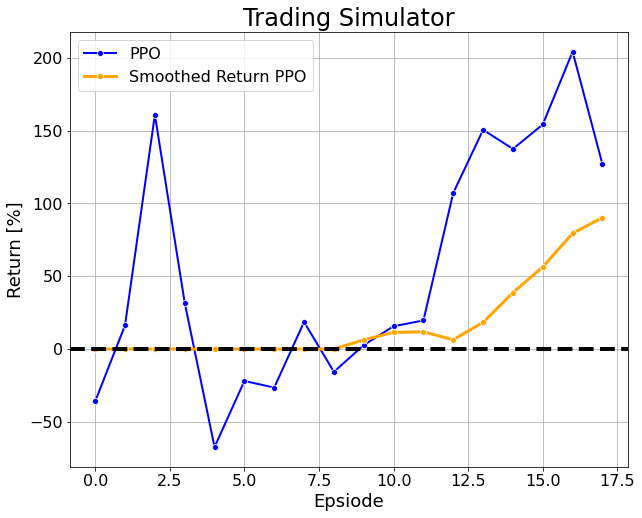

In [24]:
window = 10
df = pd.DataFrame({'episode':[x for x in range(len(scores))],
                   'score':scores})
df['score_smooth'] = df.score.rolling(window=window).mean().fillna(0)

fig = plt.figure(figsize = (10,8))
sns.lineplot(data = df, x = 'episode', y = 'score', 
             color = 'blue', label='PPO', linewidth = 2,
             marker = 'o')
sns.lineplot(data = df, x = 'episode', y = 'score_smooth', 
             color = 'orange', label='Smoothed Return PPO', linewidth = 3,
             marker = 'o')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 4)
plt.legend(fontsize = 16)
plt.ylabel('Return [%]',fontsize = 18)
plt.xlabel('Epsiode', fontsize = 18)
plt.title(f"Trading Simulator", fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()

# Test Trained Agent

## Create New Simulator Environment

To really see if the agent learned anything, let's show it a totally new scenario and see how it does.  This means new start and stop times, and also new assets.  Just make sure the number of assets is the same as used in training.

Data has 639 steps points per episode


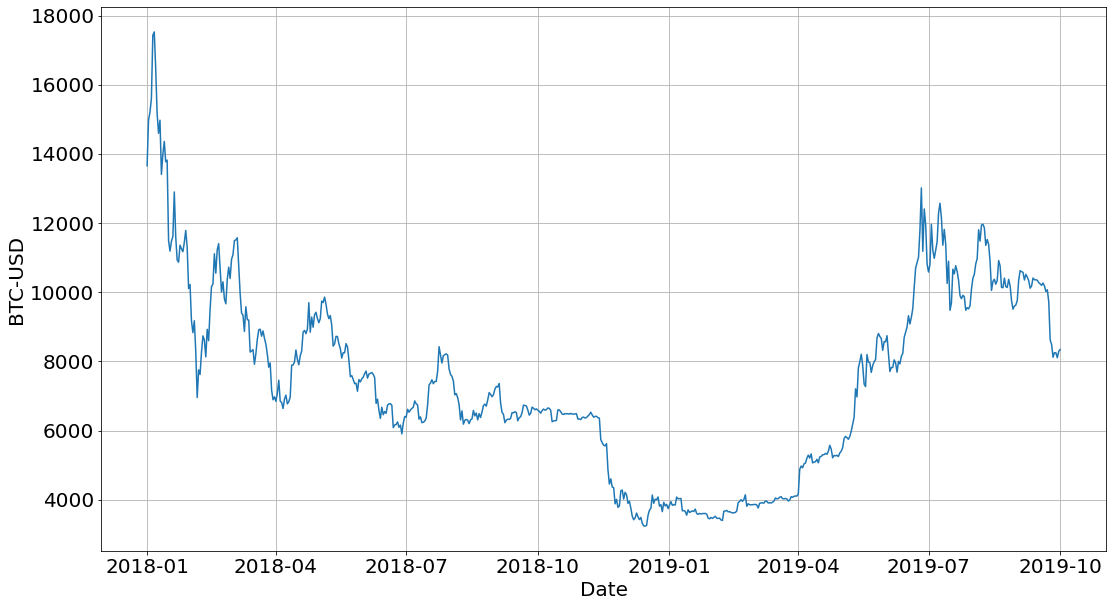

In [25]:
TICKERS_test = ['BTC-USD']
tstart_test = "2018-01-01"
tstop_test = "2019-09-30"

assert len(TICKERS) == len(TICKERS_test)
df_price_test = create_df_price(TICKERS_test, tstart_test, tstop_test)

xdaily = 100  #daily amount to spend/short [USD]
initial_cash = 100  #initial cash you start with [USD]
env_test = TradeSimulator(df_price_test, xdaily,initial_cash)
sns.lineplot(data = df_price_test, x = 'Date', y = TICKERS_test[0])

## Load Agent

In [26]:
agent_test =  torch.load('actor.pkl')


## Run test simulator

The simulator runs the agent through `env_test`.  The outputs of this code are

1. `df_values` = dataframe of the portfolio value, agent action, and color coding for plotting for each period.  The colors correspond to the different agent actions (buy, hold, sell)

In [28]:
terminal = False
env_test.reset()
signal = np.zeros(env_test.n_assets)
env_test.step(signal)
current_state= get_state(env_test, agent_window)
signals = []
values = []
actions = []
while not terminal:
    # Choose action
    prob_a = agent_test.pi(torch.FloatTensor(current_state).to(device))
    action = torch.distributions.Categorical(prob_a).mode.item()
    #action = torch.distributions.Categorical(prob_a).sample().item()

    # Act    
    signal = get_action(env_test,action)
    state_index, reward, value, terminal = env_test.step(signal)
    new_state = get_state(env_test, agent_window)

    #update current state
    current_state = new_state

    #append value of portfolio and signal
    values.append(value)
    signals.append(signal)
    actions.append(action)

print(f"PPO portfolio return is {(value/env.initial_cash-1)*100:.1f}%")
df_values = pd.DataFrame({'Date':df_price_test.Date[2:], 'value':values,'action':actions})
colors = ['blue','black','red']
df_values['color'] = [colors[x] for x in df_values.action]
df_values['price'] = df_price_test[TICKERS_test[0]]
annual_sharpe_agent = np.sqrt(365)* df_values.value.pct_change().mean()/df_values.value.pct_change().std()

print(f"Agent annualized Sharpe ratio =  {annual_sharpe_agent:.1f}")

PPO portfolio return is -75.0%
Agent annualized Sharpe ratio =  -0.2


## Plot Agent Performance

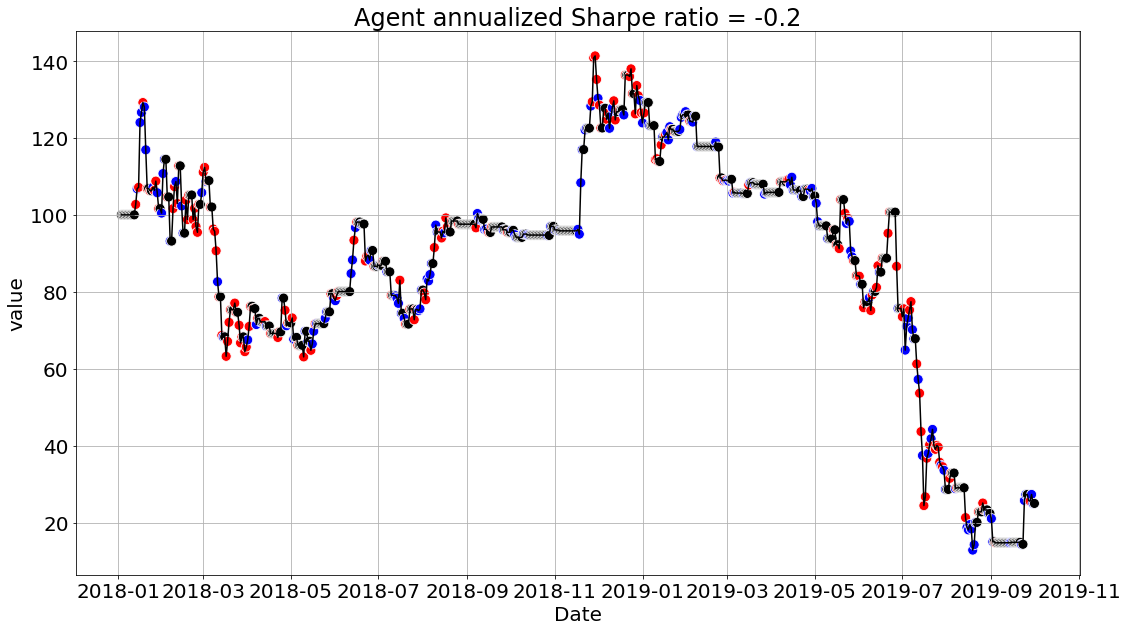

In [29]:
sns.lineplot(data = df_values, x = 'Date', y = 'value', color ='black' )
sns.scatterplot(data = df_values, x = 'Date', y = 'value', c = df_values.color, s = 100 )
plt.title(f"Agent annualized Sharpe ratio = {annual_sharpe_agent:.1f}")
plt.show()

## Baseline Signals on Test Environment

In [30]:
#buy each period
df_signals = pd.DataFrame()
df_signals['Date'] = df_price_test['Date']
for ticker in TICKERS:
  df_signals[ticker] = 1
df_signals_buy = df_signals

#sell each period
df_signals = pd.DataFrame()
df_signals['Date'] = df_price_test['Date']
for ticker in TICKERS:
  df_signals[ticker] = -1
df_signals_sell = df_signals

In [31]:
df_portfolio_buy, annual_sharpe_buy = portfolio_dataframe(env_test, df_signals_buy)
df_portfolio_sell, annual_sharpe_sell = portfolio_dataframe(env_test, df_signals_sell)

## Plot Agent vs Baseline Performance

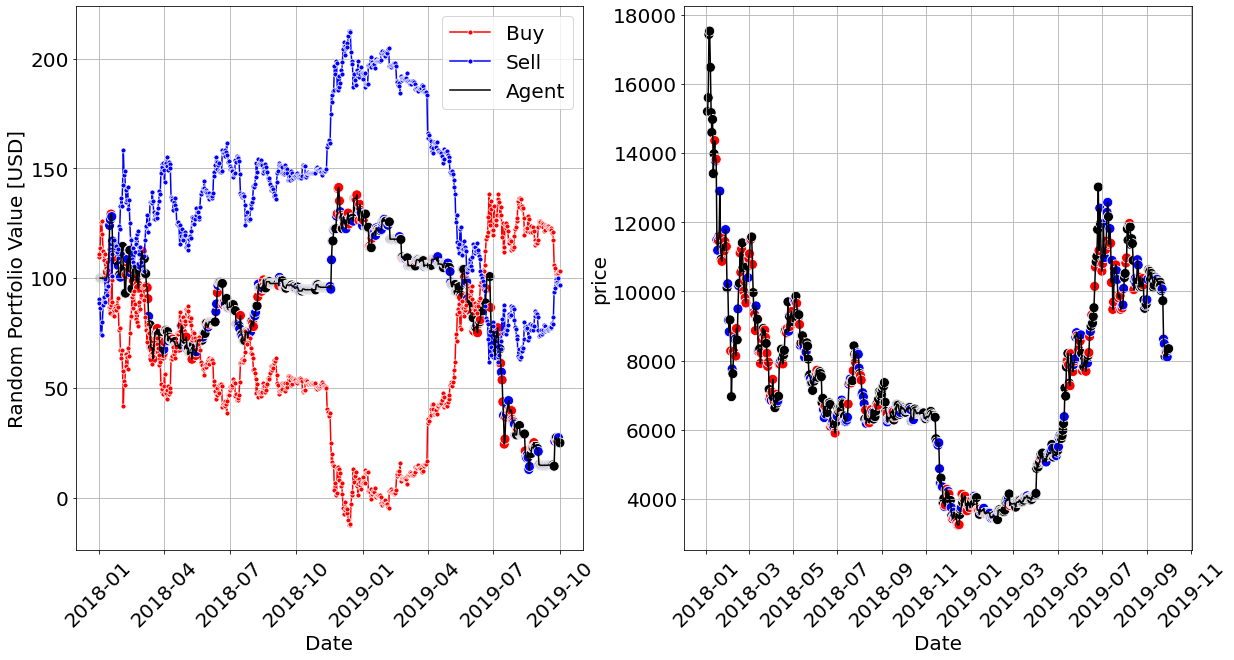

Annualized Sharpe Ratio
Buy: 0.2
Sell: 0.4
Agent: -0.2


In [32]:
s=5
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.lineplot(data = df_portfolio_buy, x = 'Date', y = 'value',marker = 'o', 
             markersize = s, color = 'red', label = "Buy")
sns.lineplot(data = df_portfolio_sell, x = 'Date', y = 'value',marker = 'o', 
             markersize = s, color = 'blue', label = "Sell")
sns.lineplot(data = df_values, x = 'Date', y = 'value', color ='black', label = 'Agent' )
sns.scatterplot(data = df_values, x = 'Date', y = 'value', c = df_values.color, s = 100 )
plt.xticks(rotation = 45)
plt.ylabel("Random Portfolio Value [USD]")

plt.subplot(1,2,2)
sns.lineplot(data = df_values, x = 'Date', 
             y = 'price', marker = '',
             color = 'black')
sns.scatterplot(data = df_values, x = 'Date', y = 'price', c = df_values.color, s = 100 )
plt.xticks(rotation = 45)

plt.show()
print(f"Annualized Sharpe Ratio")
print(f"Buy: {annual_sharpe_buy:.1f}")
print(f"Sell: {annual_sharpe_sell:.1f}")
print(f"Agent: {annual_sharpe_agent:.1f}")